# Summary statistics

`ScmRun` objects have methods specific to calculating summary statistics. In this notebook we demonstrate them.

At present, the following methods are available:

- `process_over`
- `quantiles_over`
- `groupby`
- `groupby_all_except`

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scmdata.run import ScmRun, run_append

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Helper bits and piecs

In [3]:
def new_timeseries(
    n=101,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<ScmRun (timeseries: 30, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119      K             Surface Temperature
	1   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       0   ssp119  W/m^2               Radiative Forcing
	3   example  World       1   ssp119      K             Surface Temperature
	4   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       1   ssp119  W/m^2               Radiative Forcing
	6   example  World       2   ssp119      K             Surface Temperature
	7   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       2   ssp119  W/m^2               Radiative Forcing
	9   example  World       3   ssp119      K             Surface Temperature
	10  example  World       3   ssp119    ppm  Atmospheri

## `process_over`

The `process_over` method allows us to calculate a specific set of statistics on groups of timeseries. A number of pandas functions can be called including "sum", "mean" and "describe".

In [5]:
print(runs.process_over.__doc__)


        Process the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        operation : str or func
            The operation to perform.

            If a string is provided, the equivalent pandas groupby function is used. Note
            that not all groupby functions are available as some do not make sense for
            this particular application. Additional information about the arguments for
            the pandas groupby functions can be found at <https://pandas.pydata.org/pan
            das-docs/stable/reference/groupby.html>`_.

            If a function is provided, it will be applied to each group. The function must
            take a dataframe as its first argument and return a DataFrame, Series or scalar.

            Note that quantile means the value of the data at a given point in the cumulative
        

### Mean

In [6]:
# NBVAL_IGNORE_OUTPUT
mean = runs.process_over(cols="run_id", operation="mean")
mean

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                    0.0    0.609158    1.292669    1.765122    1.789821    2.364833    3.069309  ...   38.587454   40.882083   42.861662   54.262839   28.371287   60.614981   49.820052
                        W/m^2 Radiative Forcing                      0.0    0.480864    1.007332    1.560757    2.588695    1.764075    2.633518  ...   60.660460   48.613607   45.898620   32.640594   46.942183   56.012998   38.658464
                        ppm   Atmospheric Concentrations|CO2         0.0    0.509833    1.061103    1.439227    2.147906    1.771573    1.760909  ...   39.699721   54.927246   43.121952   49.515958   50.819205   57.830008   53.309031

[3 rows x 101 columns]

### Median

In [7]:
# NBVAL_IGNORE_OUTPUT
median = runs.process_over(cols="run_id", operation="median")
median

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                    0.0    0.560583    1.580790    1.595265    1.755046    2.716709    3.043203  ...   34.667929   38.209976   23.750729   54.300156   20.964451   76.671219   53.754527
                        W/m^2 Radiative Forcing                      0.0    0.519904    0.896726    1.431066    2.755164    1.349049    2.363576  ...   59.983509   55.064678   47.075346   22.091512   52.956965   52.731056   40.998473
                        ppm   Atmospheric Concentrations|CO2         0.0    0.519161    0.958346    1.591276    2.176709    0.959356    1.328221  ...   28.152886   65.207784   38.735128   43.116132   51.459225   67.647850   59.088551

[3 rows x 101 columns]

### Arbitrary functions

You are also able to run arbitrary functions for each group

In [8]:
# NBVAL_IGNORE_OUTPUT
def mean_and_invert(df, axis=0):
    # Take a mean across the group and then invert the result
    return -df.mean(axis=axis)


runs.process_over("run_id", operation=mean_and_invert)

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                   -0.0   -0.609158   -1.292669   -1.765122   -1.789821   -2.364833   -3.069309  ...  -38.587454  -40.882083  -42.861662  -54.262839  -28.371287  -60.614981  -49.820052
                        W/m^2 Radiative Forcing                     -0.0   -0.480864   -1.007332   -1.560757   -2.588695   -1.764075   -2.633518  ...  -60.660460  -48.613607  -45.898620  -32.640594  -46.942183  -56.012998  -38.658464
                        ppm   Atmospheric Concentrations|CO2        -0.0   -0.509833   -1.061103   -1.439227   -2.147906   -1.771573   -1.760909  ...  -39.699721  -54.927246  -43.121952  -49.515958  -50.819205  -57.830008  -53.309031

[3 rows x 101 columns]

In [9]:
# NBVAL_IGNORE_OUTPUT
runs.process_over("run_id", operation=mean_and_invert, axis=1)

model    region  run_id  scenario  unit   variable                      
example  World   0       ssp119    K      Surface Temperature              -26.914607
                 1       ssp119    K      Surface Temperature              -23.123128
                 2       ssp119    K      Surface Temperature              -23.416706
                 3       ssp119    K      Surface Temperature              -24.000508
                 4       ssp119    K      Surface Temperature              -26.203683
                 5       ssp119    K      Surface Temperature              -23.362895
                 6       ssp119    K      Surface Temperature              -24.405598
                 7       ssp119    K      Surface Temperature              -23.338564
                 8       ssp119    K      Surface Temperature              -22.734094
                 9       ssp119    K      Surface Temperature              -25.340337
                 0       ssp119    W/m^2  Radiative Forcing        

### Other quantiles

In [10]:
# NBVAL_IGNORE_OUTPUT
lower_likely_quantile = runs.process_over(
    cols="run_id", operation="quantile", q=0.17
)
lower_likely_quantile

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                    0.0    0.350163    0.603902    1.065305    0.918413    0.848033    0.692652  ...    6.278998   18.319523   12.505199   37.716214    9.660315   21.991973   14.014132
                        W/m^2 Radiative Forcing                      0.0    0.198351    0.359750    0.805204    1.894396    0.626434    0.622884  ...   42.666589   15.913706   24.746273    8.993820   12.375324   26.282222    2.882030
                        ppm   Atmospheric Concentrations|CO2         0.0    0.256194    0.714367    0.670428    0.985665    0.244048    0.276441  ...    9.916508   29.509269    9.447101   21.354624   18.649498   30.247185   18.326198

[3 rows x 101 columns]

## `quantiles_over`

If you want to calculate more than one summary statistic, `quantiles_over` will calculate and label multiple summary statistics before returning them.

In [11]:
print(runs.quantiles_over.__doc__)


        Calculate quantiles of the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        quantiles
            The quantiles to calculate. This should be a list of quantiles to calculate
            (quantile values between 0 and 1). ``quantiles`` can also include the strings
            "median" or "mean" if these values are to be calculated.

        **kwargs
            Passed to :meth:`~ScmRun.process_over`.

        Returns
        -------
        :class:`pandas.DataFrame`
            The quantiles of the timeseries, grouped by all columns in :attr:`meta`
            other than :obj:`cols`. Each calculated quantile is given a label which is
            stored in the ``quantile`` column within the output index.

        Raises
        ------
        TypeError
            ``operation`` is included in ``kwargs``. The op

In [12]:
# NBVAL_IGNORE_OUTPUT
summary_stats = runs.quantiles_over(
    cols="run_id", quantiles=[0.05, 0.17, 0.5, 0.83, 0.95, "mean", "median"]
)
summary_stats

time                                                                   2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                       quantile                                                                                      ...                                                                                    
example World  ssp119   K     Surface Temperature            0.05             0.0    0.279073    0.516411    0.638010    0.576834    0.449532    0.366609  ...    4.170205    8.666613    6.126051   16.398260    4.077072    4.609459    1.028213
                        W/m^2 Radiative Forcing              0.05             0.0    0.116936    0.146816    0.565621    1.532965    0.284068    0.305239  ...   32.124388    5.223750   20.042809    5.509513    6.849793    4.188371    2.281927
                        ppm   Atmospheric Concentrations|CO2 0.05             0.0    0.056687    0.258620    0.403987    0.401822    0.125600    0.212960  ...    2.202287   11.412620    4.183282    5.677376    9.184018   15.003429   12.545491
                        K     Surface Temperature            0.17             0.0    0.350163    0.603902    1.065305    0.918413    0.848033    0.692652  ...    6.278998   18.319523   12.505199   37.716214    9.660315   21.991973   14.014132
                        W/m^2 Radiative Forcing              0.17             0.0    0.198351    0.359750    0.805204    1.894396    0.626434    0.622884  ...   42.666589   15.913706   24.746273    8.993820   12.375324   26.282222    2.882030
                        ppm   Atmospheric Concentrations|CO2 0.17             0.0    0.256194    0.714367    0.670428    0.985665    0.244048    0.276441  ...    9.916508   29.509269    9.447101   21.354624   18.649498   30.247185   18.326198
                        K     Surface Temperature            0.5              0.0    0.560583    1.580790    1.595265    1.755046    2.716709    3.043203  ...   34.667929   38.209976   23.750729   54.300156   20.964451   76.671219   53.754527
                        W/m^2 Radiative Forcing              0.5              0.0    0.519904    0.896726    1.431066    2.755164    1.349049    2.363576  ...   59.983509   55.064678   47.075346   22.091512   52.956965   52.731056   40.998473
                        ppm   Atmospheric Concentrations|CO2 0.5              0.0    0.519161    0.958346    1.591276    2.176709    0.959356    1.328221  ...   28.152886   65.207784   38.735128   43.116132   51.459225   67.647850   59.088551
                        K     Surface Temperature            0.83             0.0    0.946286    1.716789    2.662553    2.871429    3.607930    5.617159  ...   72.229168   68.681898   87.620472   77.549466   47.182758   92.225519   86.068171
                        W/m^2 Radiative Forcing              0.83             0.0    0.776358    1.773987    2.459422    3.104522    2.957480    4.708093  ...   81.577458   70.052387   67.863896   61.225080   75.615880   91.835809   64.371527
                        ppm   Atmospheric Concentrations|CO2 0.83             0.0    0.803979    1.596720    2.169187    3.517179    3.816369    3.720460  ...   79.468436   80.526546   75.038068   86.044783   83.506324   77.356637   82.646428
                        K     Surface Temperature            0.95             0.0    0.960800    1.828498    2.811069    2.948163    4.198839    5.744249  ...   83.837890   77.631703   89.024400   92.492981   66.637529   96.448064   94.749164
                        W/m^2 Radiative Forcing              0.95             0.0    0.801606    1.920678    2.626127    3.493949    4.012412    5.418576  ...   91.027960   85.389964   74.331907   75.234222   83.658858   94.234775   85.581278
                        ppm   Atmospheric Concentrations|CO2 0.95             0.0    0.878054    1.640486    2.5

### Plotting

#### Calculate quantiles within plotting function

We can use `plumeplot` directly to plot quantiles. This will calculate the quantiles as part of making the plot so if you're doing this lots it might be faster to pre-calculate the quantiles, then make the plot instead (see below)

Note that in this case the default setttings in `plumeplot` don't produce anything that helpful, we show how to modify them in the cell below.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7fd94e43ea90>])

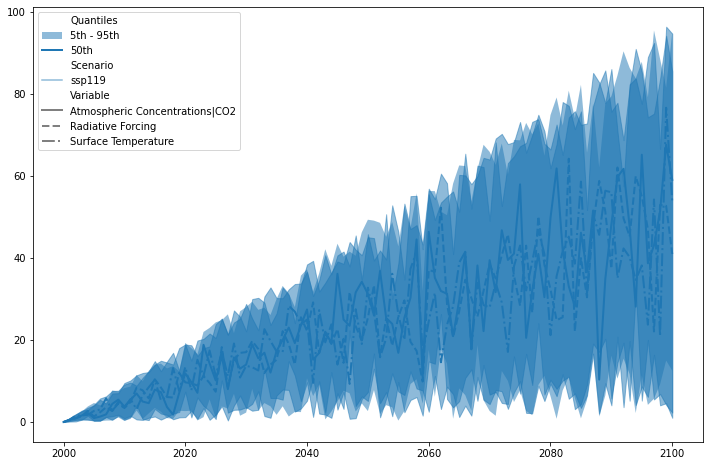

In [13]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(quantile_over="run_id")

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7fd94e2d6a90>])

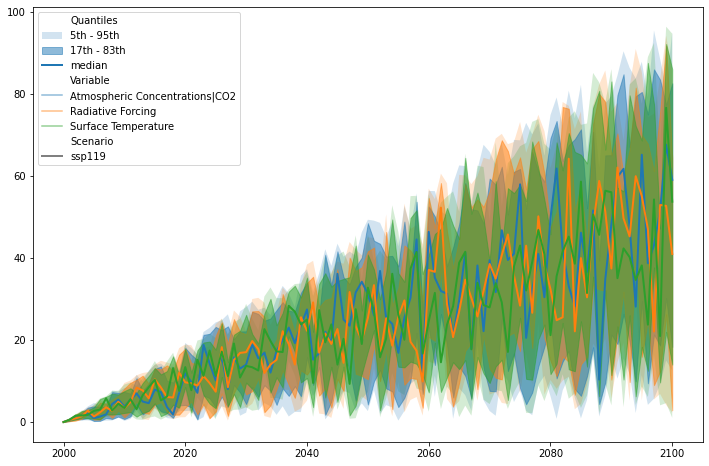

In [14]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(
    quantile_over="run_id",
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
)

#### Pre-calculated quantiles

Alternately, we can cast the output of `quantiles_over` to an `ScmRun` object for ease of filtering and plotting.

In [15]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun = ScmRun(summary_stats)
summary_stats_scmrun

<ScmRun (timeseries: 21, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model quantile region scenario   unit                        variable
	0   example     0.05  World   ssp119      K             Surface Temperature
	1   example     0.05  World   ssp119  W/m^2               Radiative Forcing
	2   example     0.05  World   ssp119    ppm  Atmospheric Concentrations|CO2
	3   example     0.17  World   ssp119      K             Surface Temperature
	4   example     0.17  World   ssp119  W/m^2               Radiative Forcing
	5   example     0.17  World   ssp119    ppm  Atmospheric Concentrations|CO2
	6   example      0.5  World   ssp119      K             Surface Temperature
	7   example      0.5  World   ssp119  W/m^2               Radiative Forcing
	8   example      0.5  World   ssp119    ppm  Atmospheric Concentrations|CO2
	9   example     0.83  World   ssp119      K             Surface Temperature
	10  example     0.83  World   ssp119  W/m^2

As discussed above, casting the output of `quantiles_over` to an `ScmRun` object helps avoid repeatedly calculating the quantiles.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7fd94e1e93a0>])

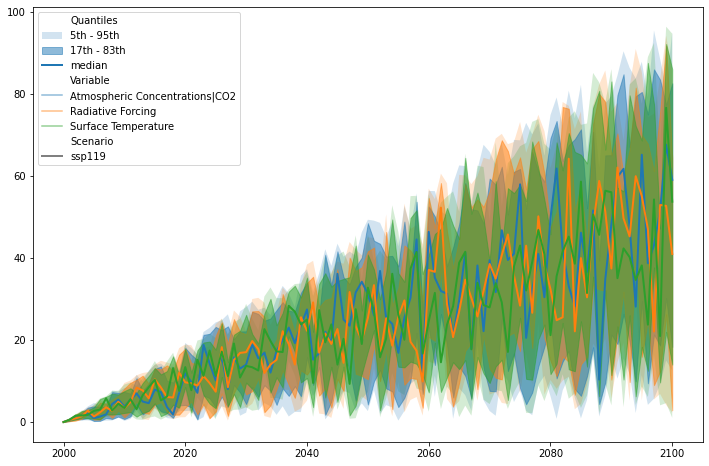

In [16]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.plumeplot(
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
    pre_calculated=True,
)

If we don't want a plume plot, we can always our standard lineplot method.

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

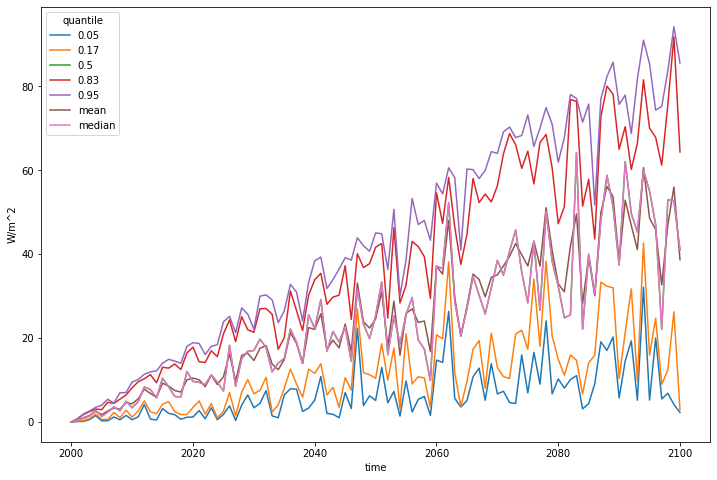

In [17]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.filter(variable="Radiative Forcing").lineplot(
    hue="quantile"
)

## `groupby`

The `groupby` method allows us to group the data by columns in `scmrun.meta` and then perform operations. An example is given below.

In [18]:
# NBVAL_IGNORE_OUTPUT
variable_means = []
for vdf in runs.groupby("variable"):
    vdf_mean = vdf.timeseries().mean(axis=0)
    vdf_mean.name = vdf.get_unique_meta("variable", True)
    variable_means.append(vdf_mean)

pd.DataFrame(variable_means)

time,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,...,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
Atmospheric Concentrations|CO2,0.0,0.509833,1.061103,1.439227,2.147906,1.771573,1.760909,...,39.699721,54.927246,43.121952,49.515958,50.819205,57.830008,53.309031
Radiative Forcing,0.0,0.480864,1.007332,1.560757,2.588695,1.764075,2.633518,...,60.660460,48.613607,45.898620,32.640594,46.942183,56.012998,38.658464
Surface Temperature,0.0,0.609158,1.292669,1.765122,1.789821,2.364833,3.069309,...,38.587454,40.882083,42.861662,54.262839,28.371287,60.614981,49.820052


## `groupby_all_except`

The `groupby_all_except` method allows us to group the data by all columns in `scmrun.meta` except for a certain set. Like with `groupby`, we can then use the groups to perform operations. An example is given below. Note that, in most cases, using `process_over` is likely to be more useful. 

In [19]:
# NBVAL_IGNORE_OUTPUT
ensemble_means = []
for edf in runs.groupby_all_except("run_id"):
    edf_mean = edf.timeseries().mean(axis=0)
    edf_mean.name = edf.get_unique_meta("variable", True)
    ensemble_means.append(edf_mean)

pd.DataFrame(ensemble_means)

time,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,...,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
Surface Temperature,0.0,0.609158,1.292669,1.765122,1.789821,2.364833,3.069309,...,38.587454,40.882083,42.861662,54.262839,28.371287,60.614981,49.820052
Radiative Forcing,0.0,0.480864,1.007332,1.560757,2.588695,1.764075,2.633518,...,60.660460,48.613607,45.898620,32.640594,46.942183,56.012998,38.658464
Atmospheric Concentrations|CO2,0.0,0.509833,1.061103,1.439227,2.147906,1.771573,1.760909,...,39.699721,54.927246,43.121952,49.515958,50.819205,57.830008,53.309031


As we said, in most cases using `process_over` is likely to be more useful. For example the above can be done using `process_over` in one line (and more metadata is retained).

In [20]:
# NBVAL_IGNORE_OUTPUT
runs.process_over("run_id", "mean")

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   K     Surface Temperature                    0.0    0.609158    1.292669    1.765122    1.789821    2.364833    3.069309  ...   38.587454   40.882083   42.861662   54.262839   28.371287   60.614981   49.820052
                        W/m^2 Radiative Forcing                      0.0    0.480864    1.007332    1.560757    2.588695    1.764075    2.633518  ...   60.660460   48.613607   45.898620   32.640594   46.942183   56.012998   38.658464
                        ppm   Atmospheric Concentrations|CO2         0.0    0.509833    1.061103    1.439227    2.147906    1.771573    1.760909  ...   39.699721   54.927246   43.121952   49.515958   50.819205   57.830008   53.309031

[3 rows x 101 columns]